### Veamos varios conceptos nuevos en acción

Estudiaremos un ejemplo de usar cross-validation para computar las validation curves de una clase de modelos.

Aquí usaremos un modelo de *regresión polinómica*: este es un modelo lineal generalizado en el cuál el grado de los polinomios es un parámetro configurable. 

Por ejemplo, un polinomio de grado 1 ajusta una línea recta a los datos; para los parámetros del modelo $a$ y $b$:

$$
y = ax + b
$$

Un polinomio de grado 3 ajusta una curva cúbica a los datos; para parámetros $a, b, c, d$: 

$$
y = ax^3 + bx^2 + cx + d
$$

Podemos generalizar esto a cualquier número de features polinómicas.

En Scikit-Learn, podmeos implementar esto con una simple regresión lineal combinada con el preprocesador polinómico (polynomial preprocessor).

Usaremos un *pipeline* para organizar secuencialmente estas operaciones. 

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Ahora vamos a crear algunos datos sintéticos (artificiales, inventados), 
a los que luego les ajustaremos nuestro modelo.

In [5]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

Ahora podemos visualizar nuestros datos, junto con los ajustes polinómicos de varios grados.

**NOTA:** Este código es auxiliar y no es necesario comprender todos los detalles para seguir el ejemplo.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


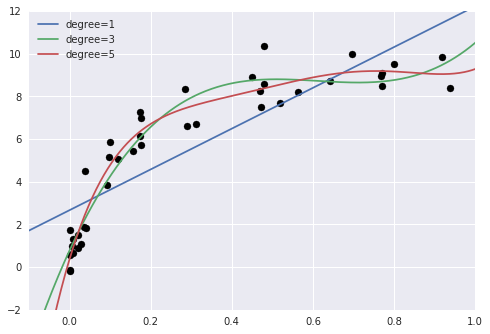

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

En este caso, "la perilla" que controla la complejidad del modelo es el grado del polinomio, el cuál puede ser cualquier entero no negativo.

Una pregunta interesante para hacernos:  qué grado de polinomio provee un compromiso apropiado entre sesgo (under-fitting) y varianza (over-fitting)?

Podemos avanzar visualizando la validation curve para este dataset y modelo particular; esto se puede hacer fácilmente usando la función ``validation_curve`` provista por Scikit-Learn.

Dado un modelo, un dataset, un nombre de parámetro, y un rango para explorar, esta función computará automáticamente tanto el score de entrenamiento como el de validación a lo largo del rango: 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


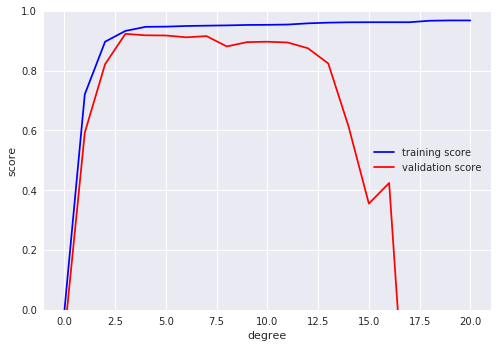

In [8]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Este gráfico muestra precisamente el comportamiento cualitativo que esperamos: el score de entrenamiento siempre es mayor que el score de validación; el score de entrenamiento crece de manera monótona junto con la complejidad del modelo; y el score de validación alcanza un máximo antes de finalmente caer a medida que el modelo sobre-ajusta. 

De la validation curve, podemos interpretar que el compromiso óptimo entre sesgo y varianza se encuentra con un polinomio de tercer orden; podemos computar y mostrar este ajuste sobre los datos originales: 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


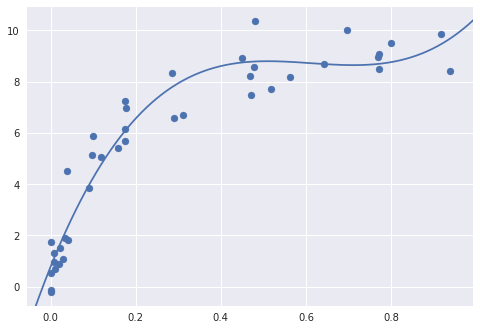

In [9]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notar que hallar este modelo óptimo no requirió que computemos sólo el score de entrenamiento, sino que examinando la relación entre los scores de entrenamiento y validación pudimos obtener un insight valiso sobre la performance del modelo.